In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
cwd = Path.cwd()
inventory_data = pd.read_csv(cwd / 'data' / 'Metro_invt_fs_uc_sfrcondo_sm_month.csv')
inventory_data.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30,2025-10-31
0,102001,0,United States,country,NaN,1421529.0,1500195.0,1592417.0,1660618.0,1709146.0,...,1062381.0,1043117.0,1097475.0,1167197.0,1262386.0,1329558.0,1373264.0,1380205.0,1373112.0,1362069.0
1,394913,1,"New York, NY",msa,NY,73707.0,80345.0,85864.0,90067.0,91881.0,...,36838.0,35370.0,37433.0,40634.0,44829.0,47708.0,49038.0,48097.0,47265.0,46757.0
2,753899,2,"Los Angeles, CA",msa,CA,21998.0,23784.0,25605.0,27109.0,28811.0,...,18129.0,18171.0,19912.0,21628.0,23659.0,25128.0,26379.0,26688.0,26539.0,25785.0
3,394463,3,"Chicago, IL",msa,IL,38581.0,42253.0,45757.0,47492.0,48984.0,...,19217.0,18165.0,18896.0,20089.0,21804.0,23133.0,24026.0,24129.0,24076.0,23981.0
4,394514,4,"Dallas, TX",msa,TX,24042.0,25876.0,28224.0,30490.0,32408.0,...,28741.0,28211.0,29656.0,31942.0,35041.0,37501.0,38954.0,39091.0,38265.0,37282.0


Plot housing supply for the 2nd row (row index 1) over time. This cell handles both common wide and long formats.

/var/folders/cr/xvl6gw5n6vx9yv0syd95dp5c0000gn/T/ipykernel_51635/533235236.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cols = pd.to_datetime(df.columns, errors='coerce')


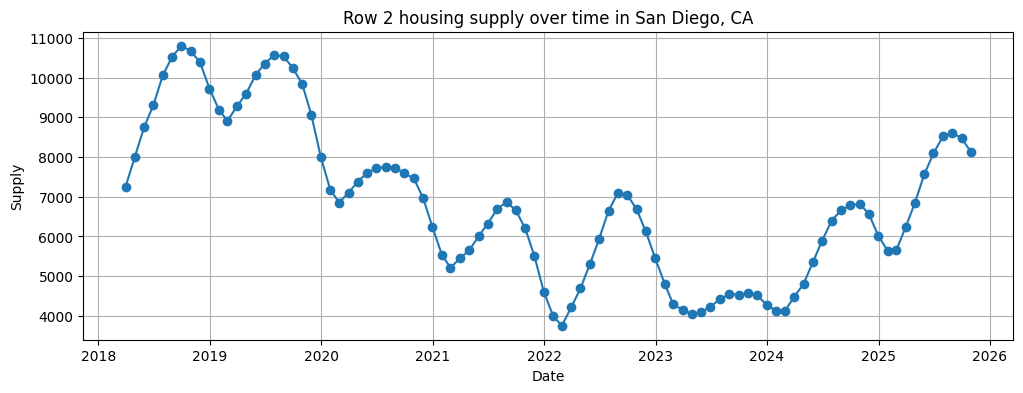

In [4]:
df = inventory_data.copy()

row_num = 17

# Case 1: long format with columns like ['period','supply'] or ['period','housing_supply']
if {'period','supply'}.issubset(df.columns) or {'period','housing_supply'}.issubset(df.columns):
    date_col = 'period'
    value_col = 'supply' if 'supply' in df.columns else 'housing_supply'
    df[date_col] = pd.to_datetime(df[date_col])
    plt.figure(figsize=(10,4))
    plt.plot(df[date_col], df[value_col], marker='o')
    plt.title(f' Housing supply over time (using)')
    plt.xlabel('Date')
    plt.ylabel('Supply')
    plt.grid(True)
    plt.show()
else:
    # Case 2: wide format where columns (except maybe first) are dates and each row is an area
    row = df.iloc[row_num]
    # Try to parse column names to datetimes
    cols = pd.to_datetime(df.columns, errors='coerce')
    mask = ~cols.isna()
    if mask.sum() >= 2:
        x = cols[mask]
        y = row[mask].astype(float)
    else:
        # If columns are not dates, try transposing and using the index as dates
        try:
            tx = df.set_index(df.columns[0]).T
            x = pd.to_datetime(tx.index, errors='coerce')
            y = tx.iloc[:,1].astype(float)
            mask = ~x.isna()
            x = x[mask]; y = y[mask]
        except Exception as e:
            raise RuntimeError('Unable to interpret dataframe format for plotting: ' + str(e))

    plt.figure(figsize=(12,4))
    plt.plot(x, y, marker='o')
    label = f"in {df.iloc[row_num,2]}"
    plt.title(f'Row 2 housing supply over time {label}')
    plt.xlabel('Date')
    plt.ylabel('Supply')
    plt.grid(True)
    plt.show()

/var/folders/cr/xvl6gw5n6vx9yv0syd95dp5c0000gn/T/ipykernel_51635/1482338951.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cols_dt = pd.to_datetime(df.columns, errors='coerce')


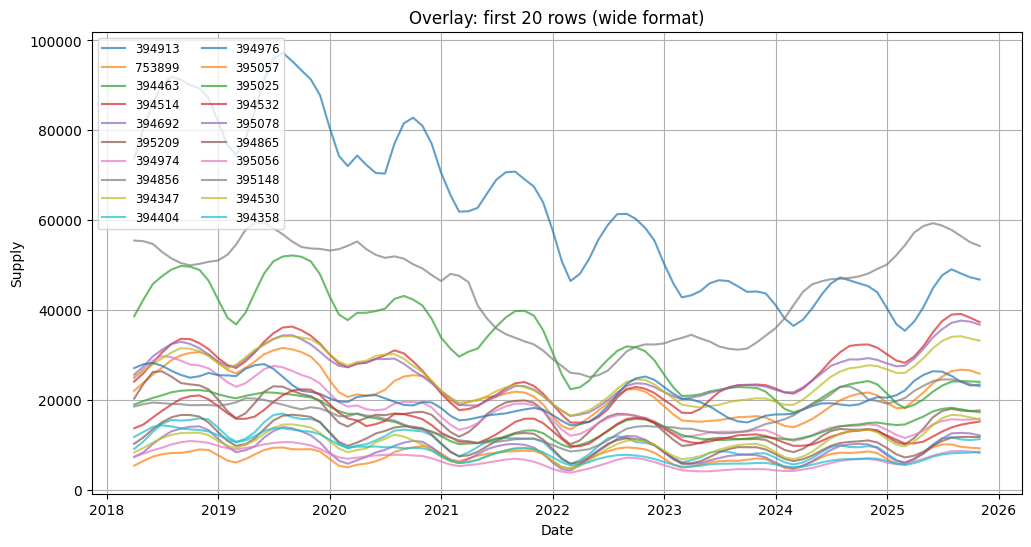

In [5]:
# Overlay housing supply for the first 20 rows (or fewer if table is smaller).
# Drop the first row as requested and work on the remainder
df = inventory_data.copy()
df = df.iloc[1:]  # ignore first row
import matplotlib.pyplot as plt
n = min(20, len(df))

# Handle long format first: expect columns like ['period', 'supply', <group>]
if {'period','supply'}.issubset(df.columns) or {'period','housing_supply'}.issubset(df.columns):
    date_col = 'period'
    value_col = 'supply' if 'supply' in df.columns else 'housing_supply'
    # try to detect a grouping column (area/name) to pivot
    group_cols = [c for c in df.columns if c not in {date_col, value_col}]
    if group_cols:
        group_col = group_cols[0]
        pivot = df.pivot_table(index=date_col, columns=group_col, values=value_col)
        pivot = pivot.sort_index()
        plt.figure(figsize=(12,6))
        x = pd.to_datetime(pivot.index)
        for col in pivot.columns[:n]:
            plt.plot(x, pivot[col], alpha=0.8, label=str(col))
        plt.title(f'Overlay: first {n} series (long format)')
        plt.xlabel('Date')
        plt.ylabel('Supply')
        plt.grid(True)
        plt.legend(loc='upper left', fontsize='small', ncol=2)
        plt.show()
    else:
        # If no grouping column, fall back to wide-format handling below
        pass

# Wide-format handling: columns are dates (or first col is an index/label)
cols_dt = pd.to_datetime(df.columns, errors='coerce')
mask = ~cols_dt.isna()
if mask.sum() >= 2:
    x = cols_dt[mask]
    plt.figure(figsize=(12,6))
    for i in range(n):
        try:
            y = df.iloc[i][mask].astype(float)
        except Exception:
            # skip rows that cannot be converted
            continue
        label = str(df.index[i]) if df.index.name is not None else (str(df.iloc[i,0]) if df.shape[1]>0 else f'row {i}')
        plt.plot(x, y, alpha=0.7, label=label)
    plt.title(f'Overlay: first {n} rows (wide format)')
    plt.xlabel('Date')
    plt.ylabel('Supply')
    plt.grid(True)
    plt.legend(loc='upper left', fontsize='small', ncol=2)
    plt.show()
else:
    # Try transposing when the first column is an identifier and rows correspond to series
    try:
        tx = df.set_index(df.columns[0]).T
        x = pd.to_datetime(tx.index, errors='coerce')
        maskx = ~x.isna()
        x = x[maskx]
        plt.figure(figsize=(12,6))
        cols = tx.columns[:n]
        for col in cols:
            try:
                y = tx[col][maskx].astype(float)
            except Exception:
                continue
            plt.plot(x, y, alpha=0.7, label=str(col))
        plt.title(f'Overlay: first {n} series (transposed)')
        plt.xlabel('Date')
        plt.ylabel('Supply')
        plt.grid(True)
        plt.legend(loc='upper left', fontsize='small', ncol=2)
        plt.show()
    except Exception as e:
        raise RuntimeError('Unable to create overlay plot: ' + str(e))

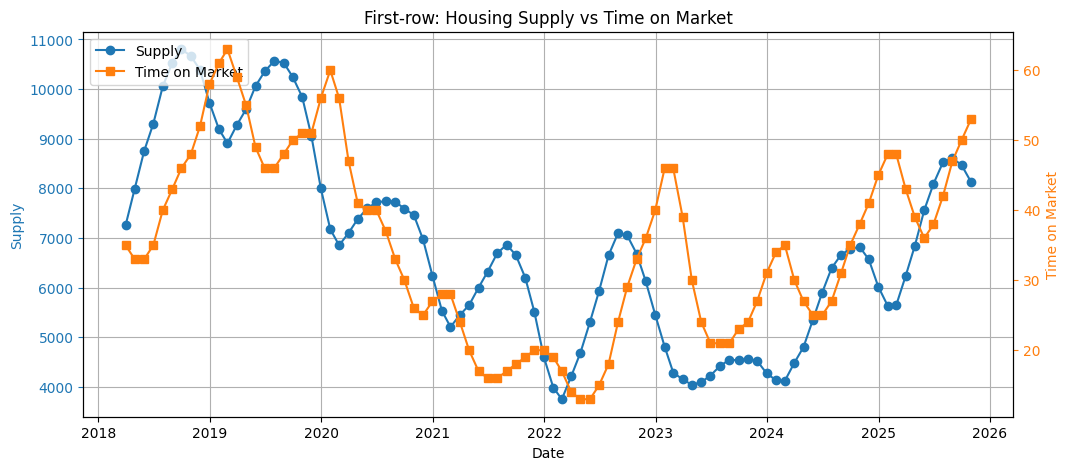

Supply sample:
2018-03-31     7253.0
2018-04-30     7992.0
2018-05-31     8753.0
2018-06-30     9304.0
2018-07-31    10056.0
Time on market sample:
2018-03-31    35.0
2018-04-30    33.0
2018-05-31    33.0
2018-06-30    35.0
2018-07-31    40.0


In [6]:
# Compare time-on-market to housing supply for the first row (wide-format CSVs)
cwd = Path.cwd()
tom_path = cwd / 'data' / 'Metro_mean_doz_pending_uc_sfrcondo_sm_month.csv'
tom = pd.read_csv(tom_path)
inv = inventory_data.copy()

def extract_wide_series(df, row_idx=0, start_col=5):
    # Assumes first N columns are metadata (RegionID,SizeRank,RegionName,RegionType,StateName)
    date_cols = df.columns[start_col:]
    dates = pd.to_datetime(date_cols, errors='coerce')
    mask = ~dates.isna()
    y = df.iloc[row_idx, start_col:][mask].astype(float)
    x = dates[mask]
    return pd.Series(data=y.values, index=x)

supply_series = extract_wide_series(inv, row_idx=17)
tom_series = extract_wide_series(tom, row_idx=17)

# Align on common dates
common = supply_series.index.intersection(tom_series.index)
supply_common = supply_series.loc[common].sort_index()
tom_common = tom_series.loc[common].sort_index()

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12,5))
ax2 = ax1.twinx()
ax1.plot(supply_common.index, supply_common.values, color='C0', marker='o', label='Supply')
ax2.plot(tom_common.index, tom_common.values, color='C1', marker='s', label='Time on Market')
ax1.set_xlabel('Date')
ax1.set_ylabel('Supply', color='C0')
ax2.set_ylabel('Time on Market', color='C1')
ax1.tick_params(axis='y', colors='C0')
ax2.tick_params(axis='y', colors='C1')
ax1.set_title('First-row: Housing Supply vs Time on Market')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc='upper left')
ax1.grid(True)
plt.show()

print('Supply sample:')
print(supply_common.head().to_string())
print('Time on market sample:')
print(tom_common.head().to_string())

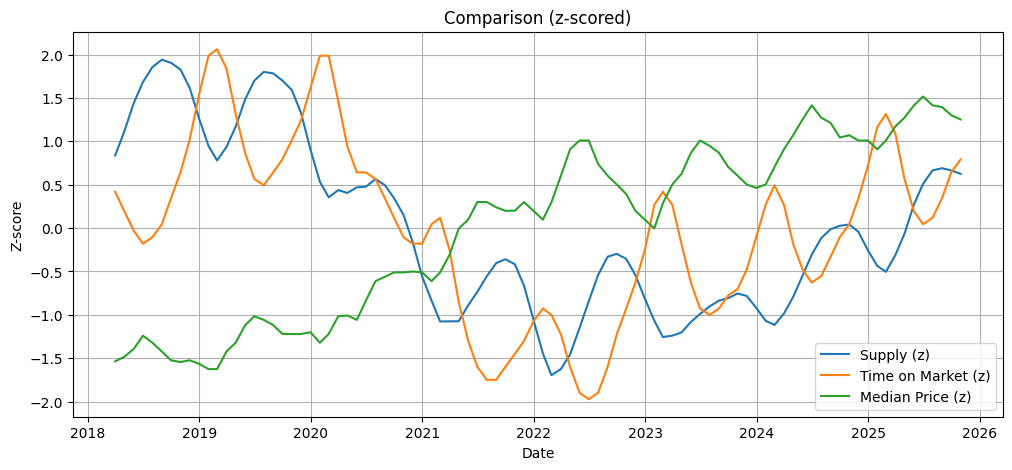

--- Original (first 5 aligned points) ---
Supply:
2018-03-31    1421529.0
2018-04-30    1500195.0
2018-05-31    1592417.0
2018-06-30    1660618.0
2018-07-31    1709146.0
Time on Market:
2018-03-31    51.0
2018-04-30    48.0
2018-05-31    45.0
2018-06-30    43.0
2018-07-31    44.0
Median Price:
2018-03-31    224408.0
2018-04-30    227000.0
2018-05-31    231500.0
2018-06-30    239000.0
2018-07-31    235000.0


In [7]:
# Compare supply, time-on-market, and median sale price for a given row
# Set either `row_idx` (integer, 0-based after header rows) or `region_name` (string) to select the series
row_idx = 0  # change to desired row index (0 = first data row)
region_name = None  # or set to e.g. 'United States' or 'New York, NY'

# Paths to the three datasets
cwd = Path.cwd()
supply_path = cwd / 'data' / 'Metro_invt_fs_uc_sfrcondo_sm_month.csv'
tom_path = cwd / 'data' / 'Metro_mean_doz_pending_uc_sfrcondo_sm_month.csv'
price_path = cwd / 'data' / 'Metro_median_sale_price_now_uc_sfrcondo_month.csv'

# Read files (use existing inventory_data if available)
supply_df = pd.read_csv(supply_path) if 'inventory_data' not in globals() else inventory_data.copy()
tom_df = pd.read_csv(tom_path)
price_df = pd.read_csv(price_path)

def find_row(df, row_idx=None, region_name=None):
    # If region_name provided and column exists, find row by RegionName
    if region_name is not None and 'RegionName' in df.columns:
        mask = df['RegionName'].astype(str) == region_name
        if mask.any():
            return df[mask].iloc[0]
        else:
            raise KeyError(f'RegionName not found')
    if row_idx is not None:
        return df.iloc[row_idx]
    raise ValueError('Provide row_idx or region_name')

def extract_series_from_row(row, df_columns, start_col=5):
    # df_columns: Index of columns from the dataframe (to parse dates)
    date_cols = df_columns[start_col:]
    dates = pd.to_datetime(date_cols, errors='coerce')
    mask = ~dates.isna()
    values = row[start_col:][mask].astype(float)
    return pd.Series(data=values.values, index=dates[mask])

# Select row (try region_name first if set)
sel_supply_row = find_row(supply_df, None if region_name else row_idx, region_name)
sel_tom_row = find_row(tom_df, None if region_name else row_idx, region_name)
sel_price_row = find_row(price_df, None if region_name else row_idx, region_name)

supply_series = extract_series_from_row(sel_supply_row, supply_df.columns)
tom_series = extract_series_from_row(sel_tom_row, tom_df.columns)
price_series = extract_series_from_row(sel_price_row, price_df.columns)

# Align dates (intersection) and sort
common = supply_series.index.intersection(tom_series.index).intersection(price_series.index)
supply_common = supply_series.loc[common].sort_index()
tom_common = tom_series.loc[common].sort_index()
price_common = price_series.loc[common].sort_index()

# Normalize each series (z-score) so they can be plotted together
def zscore(s):
    return (s - s.mean()) / s.std() if s.std() != 0 else (s - s.mean())
s_supply = zscore(supply_common)
s_tom = zscore(tom_common)
s_price = zscore(price_common)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(s_supply.index, s_supply.values, label='Supply (z)')
plt.plot(s_tom.index, s_tom.values, label='Time on Market (z)')
plt.plot(s_price.index, s_price.values, label='Median Price (z)')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.title('Comparison (z-scored)')
plt.grid(True)
plt.legend()
plt.show()

# Print samples of original series for inspection
print('--- Original (first 5 aligned points) ---')
print('Supply:')
print(supply_common.head().to_string())
print('Time on Market:')
print(tom_common.head().to_string())
print('Median Price:')
print(price_common.head().to_string())

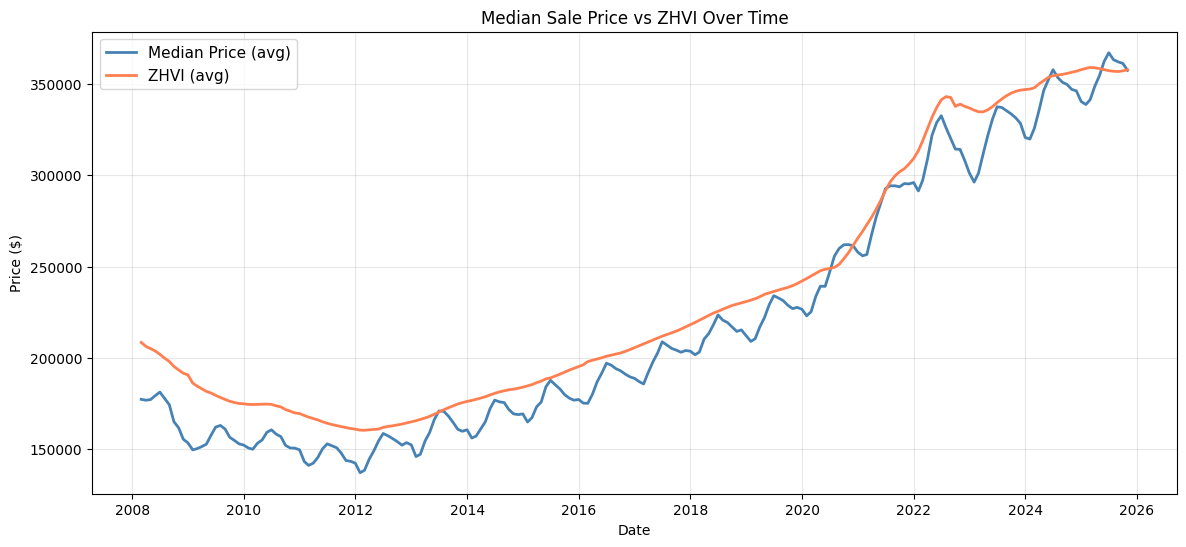


Dataset: 80,591 region-date pairs
Date range: 2008-02-29 to 2025-10-31
Regions: 387


In [8]:
# Compare median sale price to ZHVI
cwd = Path.cwd()
price_path = cwd / 'data' / 'Metro_median_sale_price_now_uc_sfrcondo_month.csv'
zhvi_path = cwd / 'data' / 'Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month (2).csv'

price_df = pd.read_csv(price_path)
zhvi_df = pd.read_csv(zhvi_path)

# Melt to long form for comparison
metadata_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']
price_long = price_df.melt(id_vars=metadata_cols, var_name='date', value_name='median_price')
zhvi_long = zhvi_df.melt(id_vars=metadata_cols, var_name='date', value_name='zhvi')

price_long['date'] = pd.to_datetime(price_long['date'], errors='coerce')
zhvi_long['date'] = pd.to_datetime(zhvi_long['date'], errors='coerce')

price_long = price_long.dropna(subset=['date'])
zhvi_long = zhvi_long.dropna(subset=['date'])

# Merge on date and region
price_long['median_price'] = pd.to_numeric(price_long['median_price'], errors='coerce')
zhvi_long['zhvi'] = pd.to_numeric(zhvi_long['zhvi'], errors='coerce')

merged = pd.merge(price_long[['RegionName', 'date', 'median_price']], 
                  zhvi_long[['RegionName', 'date', 'zhvi']], 
                  on=['RegionName', 'date'], how='inner')

merged = merged.dropna(subset=['median_price', 'zhvi'])

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 6))
dates = merged['date'].unique()
dates = sorted(dates)

# Plot aggregated daily average bias
daily_avg_price = merged.groupby('date')['median_price'].mean()
daily_avg_zhvi = merged.groupby('date')['zhvi'].mean()

ax.plot(daily_avg_price.index, daily_avg_price.values, label='Median Price (avg)', linewidth=2, color='steelblue')
ax.plot(daily_avg_zhvi.index, daily_avg_zhvi.values, label='ZHVI (avg)', linewidth=2, color='coral')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('Median Sale Price vs ZHVI Over Time')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.show()

print(f'\nDataset: {len(merged):,} region-date pairs')
print(f'Date range: {merged["date"].min().date()} to {merged["date"].max().date()}')
print(f'Regions: {merged["RegionName"].nunique()}')

In [10]:
# Average ZHVI bias calculation
import pandas as pd
from pathlib import Path

cwd = Path.cwd()
price_path = cwd / 'data' / 'Metro_median_sale_price_now_uc_sfrcondo_month.csv'
zhvi_path = cwd / 'data' / 'Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month (2).csv'

price_df = pd.read_csv(price_path)
zhvi_df = pd.read_csv(zhvi_path)

# Melt to long form
price_long = price_df.melt(id_vars=list(price_df.columns[:5]), var_name='date', value_name='median_price')
zhvi_long = zhvi_df.melt(id_vars=list(zhvi_df.columns[:5]), var_name='date', value_name='zhvi')

price_long['date'] = pd.to_datetime(price_long['date'], errors='coerce')
zhvi_long['date'] = pd.to_datetime(zhvi_long['date'], errors='coerce')

price_long = price_long.dropna(subset=['date'])
zhvi_long = zhvi_long.dropna(subset=['date'])

# Merge on RegionName and date
price_long['RegionName'] = price_long['RegionName'].astype(str)
zhvi_long['RegionName'] = zhvi_long['RegionName'].astype(str)

merged = pd.merge(price_long, zhvi_long, on=['RegionName','date'], how='inner')
merged['median_price'] = pd.to_numeric(merged['median_price'], errors='coerce')
merged['zhvi'] = pd.to_numeric(merged['zhvi'], errors='coerce')
merged = merged.dropna(subset=['median_price','zhvi'])

# Calculate how far off ZHVI is on average
merged['rel_diff'] = (merged['zhvi'] - merged['median_price']) / merged['median_price']
mean_bias = merged['rel_diff'].mean()

print('='*70)
print('ZHVI AVERAGE BIAS')
print('='*70)
print(f'\nOn average, ZHVI is {abs(mean_bias)*100:.2f}% {"HIGHER" if mean_bias > 0 else "LOWER"} than median sale price')
print(f'Mean bias: {mean_bias:.4f} ({mean_bias*100:.2f}%)')
print(f'Median bias: {merged["rel_diff"].median():.4f} ({merged["rel_diff"].median()*100:.2f}%)')
print(f'Std deviation: {merged["rel_diff"].std():.4f}')
print(f'Sample size: {len(merged):,} region-date pairs')
print('='*70)

ZHVI AVERAGE BIAS

On average, ZHVI is 7.76% HIGHER than median sale price
Mean bias: 0.0776 (7.76%)
Median bias: 0.0661 (6.61%)
Std deviation: 0.1335
Sample size: 80,591 region-date pairs
